In [6]:
import yfinance as yf
import pandas as pd

tickers = [
    'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META',
    'TSLA', 'NVDA', 'JPM', 'JNJ', 'V',
    'SPY', 'QQQ', 'DIA', 'IWM', 'ARKK',
    'XLF', 'XLK', 'XLV', 'XLE', 'XLY'
]

data = yf.download(tickers, start="2015-01-01", end="2025-08-01", group_by='ticker', auto_adjust=False)

[*********************100%***********************]  20 of 20 completed


In [75]:
def count_candle_streaks(n,data):
    up_streaks=0
    up_followed__by_red = 0
    down_streaks=0
    down_followed_by_green=0

    for ticker in tickers:
        df = data[ticker][['Open','Close']].dropna()
        candle_color = df['Close'] > df['Open'] #True: green, False: red
        candle_series = candle_color.values

        i=0
        while i < len(candle_series)-n:
            #Check for green streak
            if all(candle_series[i+j] for j in range(n)):
                up_streaks += 1
                if i + n < len(candle_series) and not candle_series[i+n]:
                    up_followed__by_red += 1
                i += n
            
            #Check for red streak
            elif all(not candle_series[i+j] for j in range(n)):
                down_streaks += 1
                if i + n < len(candle_series) and candle_series[i+n]:
                    down_followed_by_green += 1
                i += n
            else:
                i += 1
    
    up_fraction = up_followed__by_red/up_streaks if up_streaks > 0 else 0
    down_fraction = down_followed_by_green/down_streaks if down_streaks > 0 else 0

    return {
        f"{n} green candles followed by red (fraction)": up_fraction,
        f"{n} red candles followed by green (fraction)": down_fraction,

    }

In [81]:
metrics = count_candle_streaks(10, data)
print(metrics)

{'10 green candles followed by red (fraction)': 0.4375, '10 red candles followed by green (fraction)': 0.6538461538461539}


In [82]:
from backtesting import Strategy, Backtest

class LongShortStrategy(Strategy):
    """
    Long: after n red candles, buy at next open, close at same bar close.
    Short: after n green candles, sell at next open, close at same bar close.
    """

    n=3

    def init(self):
        pass

    def next(self):
        if len(self.data) < self.n:
            return

        open_ = self.data.Open
        close_ = self.data.Close

        #Long
        if all(close_[-1] < open_[-1] for i in range(1, self.n+1)):
            self.buy()
        
        #Short
        elif all(close_[-i] > open_[-1] for i in range(1, self.n+1)):
            self.sell()
        
        #Always close open positions at the same bar's close
        if self.position:
            self.position.close()

In [83]:
from backtesting import Strategy, Backtest

class LongStrategy(Strategy):
    """
    Long: after n red candles, buy at next open, close at same bar close.
    Short: after n green candles, sell at next open, close at same bar close.
    """

    n=3

    def init(self):
        pass

    def next(self):
        if len(self.data) < self.n:
            return

        open_ = self.data.Open
        close_ = self.data.Close

        #Long
        if all(close_[-1] < open_[-1] for i in range(1, self.n+1)):
            self.buy()
        
        #Always close open positions at the same bar's close
        if self.position:
            self.position.close()

Returns for each ticker:
AAPL: 473.90%
MSFT: 726.83%
GOOGL: 351.38%
AMZN: 356.54%
META: 1511.80%
TSLA: 361.97%
NVDA: 8136.75%
JPM: 50.82%
JNJ: -23.81%
V: 570.59%
SPY: 40.49%
QQQ: 239.85%
DIA: 22.30%
IWM: 23.28%
ARKK: 164.01%
XLF: 49.40%
XLK: 488.22%
XLV: 2.21%
XLE: 22.44%
XLY: 103.91%

=== Aggregated Metrics ===
Sum of Returns: 13672.88%
Average Returns: 683.64%
Maximum Drawdown across all tickers: -79.17%


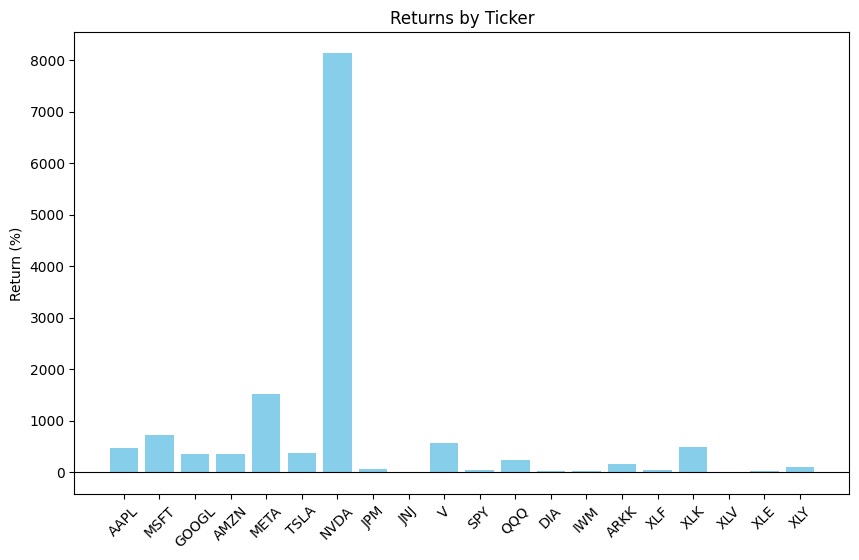

In [88]:
import numpy as np
import matplotlib.pyplot as plt

results = {}

for symbol in tickers:
    df = data[symbol][['Open', 'High', 'Low', 'Close', 'Volume']]#.dropna()
    df.columns = ['Open', 'High', 'Low', 'Close', 'Volume']

    bt = Backtest(df,
                  LongStrategy,
                  cash = 100_000,
                  commission= 0.0002,
                  exclusive_orders=True,
                  margin=1,
                  finalize_trades=True)
    stats = bt.run()
    results[symbol] = stats

returns_list = [(sym,ret['Return [%]']) for sym,ret in results.items()]

print("Returns for each ticker:")
for sym, ret in returns_list:
    print(f"{sym}: {ret:.2f}%")

sum_of_returns = sum(ret for _, ret in returns_list)
average_return = np.mean([ret for _, ret in returns_list])
max_drawdowns = [(sym, ret['Max. Drawdown [%]']) for sym, ret in results.items()]
max_drawdowns_overall = min(mdd for _, mdd in max_drawdowns)

print("\n=== Aggregated Metrics ===")
print(f"Sum of Returns: {sum_of_returns:.2f}%")
print(f"Average Returns: {average_return:.2f}%")
print(f"Maximum Drawdown across all tickers: {max_drawdowns_overall:.2f}%")


tickers = [sym for sym, _ in returns_list]
returns = [ret for _, ret in returns_list]

plt.figure(figsize=(10, 6))
plt.bar(tickers, returns, color='skyblue')
plt.title("Returns by Ticker")
plt.ylabel("Return (%)")
plt.xticks(rotation=45)
plt.axhline(0, color='black', linewidth=0.8)  # baseline
plt.show()